------------------------------------------------------------
IMAGE COMPRESSION ANALYSIS FOR: mountains.webp
------------------------------------------------------------

## 1. Lossless Compression (Pure Huffman)
----------------------------------------
Technique: Huffman Coding on Raw Pixels
CR: 1.08:1 | BPP: 7.3755 | PSNR: Infinity
----------------------------------------

## 2. Lossy Compression (DCT Hybrid)
----------------------------------------

--- Lossy Analysis: Quality Factor = 10 ---
Technique: DCT + Quantization + Huffman
CR: 7.11:1 | BPP: 1.1246 | PSNR: 26.76 dB
----------------------------------------

--- Lossy Analysis: Quality Factor = 50 ---
Technique: DCT + Quantization + Huffman
CR: 5.25:1 | BPP: 1.5233 | PSNR: 29.64 dB
----------------------------------------

--- Lossy Analysis: Quality Factor = 90 ---
Technique: DCT + Quantization + Huffman
CR: 3.08:1 | BPP: 2.5950 | PSNR: 32.01 dB
----------------------------------------

## 3. Visualization and Summary


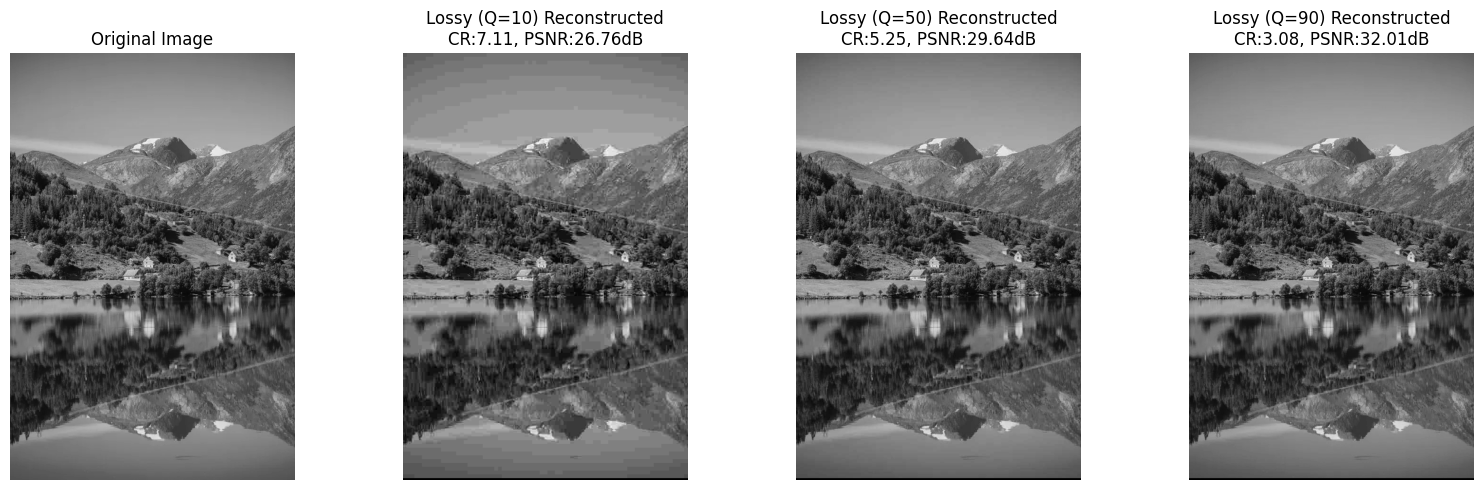


--- Consolidated Metrics Table for Report ---
Type       | Q Factor | CR       | BPP      | PSNR (dB) 
--------------------------------------------------
Lossless   | N/A      | 1.08     | 7.3755   | Inf       
Lossy      | 10       | 7.11     | 1.1246   | 26.76     
Lossy      | 50       | 5.25     | 1.5233   | 29.64     
Lossy      | 90       | 3.08     | 2.5950   | 32.01     


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import os
import math



class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other): return self.freq < other.freq

def build_huffman_tree(data):
    frequency = Counter(data)
    if not frequency: return None, {}
    priority_queue = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(priority_queue)
    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue); right = heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq); merged.left = left; merged.right = right
        heapq.heappush(priority_queue, merged)
    return priority_queue[0] if priority_queue else None, frequency

def generate_huffman_codes(root, current_code="", codes=None):
    if codes is None: codes = {}
    if root is None: return codes
    if root.char is not None: codes[root.char] = current_code; return codes
    generate_huffman_codes(root.left, current_code + "0", codes); generate_huffman_codes(root.right, current_code + "1", codes)
    return codes

def calculate_total_bits(data_stream, codes):
    return sum(len(codes.get(item, "")) for item in data_stream)



# Standard JPEG Luminance Quantization Matrix
Q_MATRIX_BASE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56], [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77], [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101], [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float32)

def get_scaled_q_matrix(quality_factor):
    scale = 50.0 / quality_factor if quality_factor <= 50 else 2.0 - 2.0 * quality_factor / 100.0
    Q = np.floor(Q_MATRIX_BASE * scale).astype(np.int32); Q[Q == 0] = 1
    return Q



def compress_dct(img, block=8, Q_matrix=Q_MATRIX_BASE):
    h, w = img.shape; coeffs = []
    for i in range(0, h, block):
        for j in range(0, w, block):
            sub = img[i:i+block, j:j+block]
            if sub.shape != (block, block): continue
            shifted_block = sub.astype(np.float32) - 128
            dct_block = cv2.dct(shifted_block)
            quantized_block = np.round(dct_block / Q_matrix).astype(np.int32)
            coeffs.extend(quantized_block.flatten().tolist())
    codes = generate_huffman_codes(build_huffman_tree(coeffs)[0]); total_bits = calculate_total_bits(coeffs, codes)
    return coeffs, codes, total_bits

def decompress_dct(coeffs, shape, block=8, Q_matrix=Q_MATRIX_BASE):
    out = np.zeros(shape, dtype=np.float32); idx = 0; h, w = shape
    for i in range(0, h, block):
        for j in range(0, w, block):
            if i+block > h or j+block > w: continue
            block_coeffs = np.array(coeffs[idx:idx + block**2]).reshape(block, block); idx += block**2
            dequantized_block = block_coeffs * Q_matrix
            reconstructed_block = cv2.idct(dequantized_block.astype(np.float32))
            sub = reconstructed_block + 128
            out[i:i+block, j:j+block] = sub
    return np.clip(out, 0, 255).astype(np.uint8)

def compress_lossless(img):
    flat = img.flatten().tolist()
    codes = generate_huffman_codes(build_huffman_tree(flat)[0])
    total_bits = calculate_total_bits(flat, codes)
    return codes, total_bits



def calculate_bpp(original_size_bytes, encoded_bits_length):
    cr = original_size_bytes / (encoded_bits_length / 8); bpp = encoded_bits_length / original_size_bytes
    return bpp, cr

def calculate_psnr(original_img, compressed_img):
    mse = np.mean((original_img.astype(np.float64) - compressed_img.astype(np.float64)) ** 2)
    if mse == 0: return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr



if __name__ == '__main__':
    
    sample_image_path = "mountains.webp" 
    original_img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

    if original_img is None:
        print(f"FATAL ERROR: Could not load image at '{sample_image_path}'. Ensure file is in the correct directory.")
        exit()

    print("-" * 60)
    print(f"IMAGE COMPRESSION ANALYSIS FOR: {os.path.basename(sample_image_path)}")
    print("-" * 60)

    
    QUALITY_FACTORS = [10, 50, 90]
    results = []
    reconstructed_images = []
    orig_bytes = original_img.size 
    
    # --- 5.1 Lossless Analysis (Pure Huffman) ---
    
    print("\n## 1. Lossless Compression (Pure Huffman)")
    print("-" * 40)
    _, lossless_bits = compress_lossless(original_img)
    bpp_lossless, cr_lossless = calculate_bpp(orig_bytes, lossless_bits)
    print(f"Technique: Huffman Coding on Raw Pixels")
    print(f"CR: {cr_lossless:.2f}:1 | BPP: {bpp_lossless:.4f} | PSNR: Infinity")
    print("-" * 40)

    # --- 5.2 Lossy Analysis Loop ---

    print("\n## 2. Lossy Compression (DCT Hybrid)")
    print("-" * 40)

    for Q in QUALITY_FACTORS:
        print(f"\n--- Lossy Analysis: Quality Factor = {Q} ---")
        
        Q_matrix_scaled = get_scaled_q_matrix(Q)
        
        coeffs, _, lossy_bits = compress_dct(original_img, Q_matrix=Q_matrix_scaled)
        recon = decompress_dct(coeffs, original_img.shape, Q_matrix=Q_matrix_scaled)
        
        
        bpp_lossy, cr_lossy = calculate_bpp(orig_bytes, lossy_bits)
        psnr_value = calculate_psnr(original_img, recon) 

        results.append({'Q': Q, 'CR': cr_lossy, 'BPP': bpp_lossy, 'PSNR': psnr_value})
        reconstructed_images.append(recon)
        
        print(f"Technique: DCT + Quantization + Huffman")
        print(f"CR: {cr_lossy:.2f}:1 | BPP: {bpp_lossy:.4f} | PSNR: {psnr_value:.2f} dB")
        print("-" * 40)

    
    
    print("\n## 3. Visualization and Summary")

    num_plots = len(QUALITY_FACTORS) + 1
    plt.figure(figsize=(4 * num_plots, 5))

    
    plt.subplot(1, num_plots, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image", fontsize=12) 
    plt.axis('off')
    for i, (res, img) in enumerate(zip(results, reconstructed_images)):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(img, cmap='gray')
        
      
        title = f"Lossy (Q={res['Q']}) Reconstructed\nCR:{res['CR']:.2f}, PSNR:{res['PSNR']:.2f}dB"
        plt.title(title, fontsize=12) 
        plt.axis('off')

    plt.tight_layout(); plt.show()

   
    print("\n--- Consolidated Metrics Table for Report ---")
    print(f"{'Type':<10} | {'Q Factor':<8} | {'CR':<8} | {'BPP':<8} | {'PSNR (dB)':<10}")
    print("-" * 50)
    print(f"{'Lossless':<10} | {'N/A':<8} | {cr_lossless:<8.2f} | {bpp_lossless:<8.4f} | {'Inf':<10}")
    for res in results:
        print(f"{'Lossy':<10} | {res['Q']:<8} | {res['CR']:<8.2f} | {res['BPP']:<8.4f} | {res['PSNR']:<10.2f}")